# Generating / Predicting Text Using LSTM's

Using a dataset containing Irish Lyrics, let's build a model that can predic the next word and subsequently generate entire texts using recursively.

### Imports

In [14]:
import tensorflow as tf
import numpy as np 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

### Load Data & Build Vocabulary

In [7]:
# Load the dataset
data = open('./irish-lyrics-eof.txt').read()

# Lowercase and split the text
corpus = data.lower().split("\n")

# Initialize the Tokenizer class
tokenizer = Tokenizer()

# Generate dictionary
tokenizer.fit_on_texts(corpus)

# Total words = vocab + OOV
total_words = len(tokenizer.word_index) + 1

print(f'total words: {total_words}')

total words: 2690


## Preprocessing the Dataset

In [8]:
# Initialize the sequences list
input_sequences = []

# Loop over every line
for line in corpus:

	# Tokenize the current line
	token_list = tokenizer.texts_to_sequences([line])[0]

	# Loop over the line several times to generate the subphrases
	for i in range(1, len(token_list)):
		
		# Generate the subphrase
		n_gram_sequence = token_list[:i+1]

		# Append the subphrase to the sequences list
		input_sequences.append(n_gram_sequence)

# Get the length of the longest line
max_sequence_len = max([len(x) for x in input_sequences])

# Pad all sequences
input_sequences = pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre')

# Create inputs and label by splitting the last token in the subphrases
xs, labels = input_sequences[:,:-1],input_sequences[:,-1]

# Convert the label into one-hot arrays
ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)

Let's check it all makes sense still

In [9]:
# Get sample sentence
sentence = corpus[0].split()
print(f'sample sentence: {sentence}')

# Initialize token list
token_list = []

# Look up the indices of each word and append to the list
for word in sentence: 
  token_list.append(tokenizer.word_index[word])

# Print the token list
print(token_list)

sample sentence: ['come', 'all', 'ye', 'maidens', 'young', 'and', 'fair']
[51, 12, 96, 1217, 48, 2, 69]


### Build and Compile Model

In [10]:
# Hyperparameters
embedding_dim = 100
lstm_units = 150
learning_rate = 0.01

# Build model
model = Sequential([
          Embedding(total_words, embedding_dim, input_length=max_sequence_len-1),
          Bidirectional(LSTM(lstm_units)),
          Dense(total_words, activation='softmax')
])

# Compile model
model.compile(
    loss='categorical_crossentropy', 
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
    metrics=['accuracy']
    )

# Print model summary
model.summary()

2023-09-21 16:13:51.854938: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-21 16:13:51.855668: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-21 16:13:51.856045: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 15, 100)           269000    
                                                                 
 bidirectional (Bidirectiona  (None, 300)              301200    
 l)                                                              
                                                                 
 dense (Dense)               (None, 2690)              809690    
                                                                 
Total params: 1,379,890
Trainable params: 1,379,890
Non-trainable params: 0
_________________________________________________________________


### Train Model

In [12]:
epochs = 30

# Train the model
history = model.fit(xs, ys, epochs=epochs)

Epoch 1/30
377/377 [==============================] - 8s 21ms/step - loss: 1.2464 - accuracy: 0.7015
Epoch 2/30
377/377 [==============================] - 8s 22ms/step - loss: 1.1776 - accuracy: 0.7082
Epoch 3/30
377/377 [==============================] - 8s 22ms/step - loss: 1.1241 - accuracy: 0.7232
Epoch 4/30
377/377 [==============================] - 8s 21ms/step - loss: 1.1064 - accuracy: 0.7260
Epoch 5/30
377/377 [==============================] - 8s 22ms/step - loss: 1.0816 - accuracy: 0.7315
Epoch 6/30
377/377 [==============================] - 7s 19ms/step - loss: 1.0586 - accuracy: 0.7342
Epoch 7/30
377/377 [==============================] - 8s 21ms/step - loss: 1.0524 - accuracy: 0.7332
Epoch 8/30
377/377 [==============================] - 8s 21ms/step - loss: 1.0902 - accuracy: 0.7200
Epoch 9/30
377/377 [==============================] - 8s 22ms/step - loss: 1.1089 - accuracy: 0.7158
Epoch 10/30
377/377 [==============================] - 8s 20ms/step - loss: 1.0339 - accura

### Visualise Results

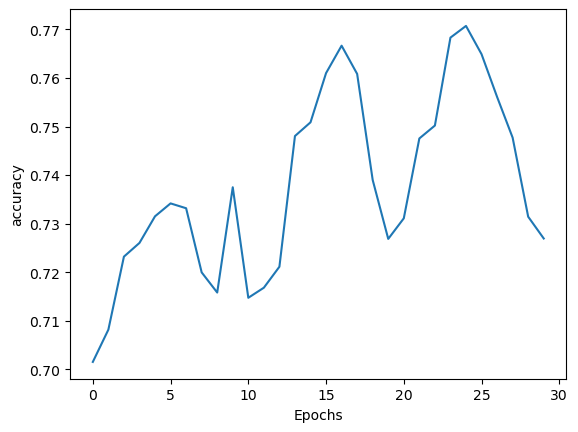

In [15]:
def plot_graphs(history, string):
  '''Function to plot training accuracy'''
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

plot_graphs(history, 'accuracy')

At around epoch 15,  the accuracy fluctuates massively. Let's see how the model does at predicting next words anyway...

### Generating / Predicting Text

Let's give the model a starting sentence & from here it can generate it's own text by predicting the next word & repeating the process.

Note: in order to avoid geting stuck in a loop repeating the same words, we randomly choose one of the 3 most likely next words instead of the most liekly next word.

In [16]:
# Define seed text
seed_text = "help me obi-wan kinobi youre my only hope"

# Define total words to predict
next_words = 100

# Loop until desired length is reached
for _ in range(next_words):

  # Convert the seed text to a token sequence
  token_list = tokenizer.texts_to_sequences([seed_text])[0]

  # Pad the sequence
  token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')

  # Feed to the model and get the probabilities for each index
  probabilities = model.predict(token_list, verbose=0)

  # Pick a random number from [1,2,3]
  choice = np.random.choice([1,2,3])

  # Choose random word
  predicted = np.argsort(probabilities)[0][-choice]

  # Ignore if index is 0 because that is just the padding.
  if predicted != 0:
    
    # Look up the word associated with the index. 
    output_word = tokenizer.index_word[predicted]

    # Combine with the seed text
    seed_text += " " + output_word

# Print the result	
print(seed_text)

2023-09-21 16:20:15.484777: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-09-21 16:20:15.485195: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-09-21 16:20:15.485762: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

help me obi-wan kinobi youre my only hope and i wonder true she said she had i had sinking many eyes too boneless she may steer i be that ever i love you so love from love a man horse was thinking gone oer the praties of singing their bundle that i well my blessing love here and she vowed that love i you cannot hear you is your own lad of athy the creole since in love is the eyes of yore sad safely good throbbing ould again corporal sun moth died gone by lord cornwall disquieted hat had fill at why them know i be till


Whilst the structure if words seems in the right ballpark, it's clear we have some way to go to create a 100% accurate sentence!